<h1 style=font:garmond;font-size:50px;color:orange;text-align:left>Predict ML</h1>

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from typing import List
from sklearn.preprocessing import StandardScaler
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
from main import Review, Timer #, Lottery

<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Transformation</h2>

In [2]:
base_df = pd.read_csv('data.csv', names=['A', 'B', 'C', 'D', 'E', 'F'])
df = base_df.iloc[:-1]
# Using all but final row of dataframe for model, and final row as target for testing and model validation
scaler = StandardScaler().fit(df.values)
transformed_dataset = scaler.transform(df.values)
transformed_dataframe = pd.DataFrame(data=transformed_dataset, index=df.index)

In [3]:
df.head()

,A,B,C,D,E,F
0,7,25,11,8,20,32
1,5,19,13,42,21,28
2,4,10,18,35,36,38
3,8,16,17,23,29,32
4,4,7,10,16,27,41


In [4]:
number_of_rows: int = df.values.shape[0]
number_of_features: int = df.values.shape[1]
window_size: int = 21

In [5]:
train = np.empty([number_of_rows-window_size, window_size, number_of_features], dtype=float)
label = np.empty([number_of_rows-window_size, number_of_features], dtype=float)

for i in range(0, number_of_rows-window_size):
    train[i]=transformed_dataframe.iloc[i:i+window_size, 0: number_of_features]
    label[i]=transformed_dataframe.iloc[i+window_size: i+window_size+1, 0: number_of_features]

# print(f'{train.shape=}\n{label.shape=}')

<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Training</h2>

In [6]:
LSTM_NODES: int = 240
DENSE_LAYERS: int = 6
DROPOUT_VARIANCE: float = 0.2

In [7]:
model = Sequential()
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Dropout(DROPOUT_VARIANCE))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Dropout(DROPOUT_VARIANCE))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=True)))
model.add(Bidirectional(LSTM(LSTM_NODES, input_shape=(window_size, number_of_features), return_sequences=False)))
model.add(Dense(DENSE_LAYERS))
model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])    # NOQA

In [8]:
timer = Timer()
timer.start()

batch_size: int = 28
epochs: int = 1

history = model.fit(train, label, batch_size=batch_size, epochs=epochs)

timer.stop()

74/74 [==============================] - 14s 94ms/step - loss: 1.0126 - accuracy: 0.1706
Time taken: 14.364


<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Prediction</h2>


In [9]:
timer.start()

to_predict = np.array(df)
scaled_to_predict = scaler.transform(to_predict)

scaled_prediction = model.predict(np.array([scaled_to_predict]))
np_prediction: List[int] = scaler.inverse_transform(scaled_prediction).astype(int)[0]

timer.stop()

print('\nPrediction: ', end='')
print(*np_prediction, sep=', ')

1/1 [==============================] - 54s 54s/step
Time taken: 53.98

Prediction: 6, 13, 18, 24, 31, 36


<h2 style=font:garmond;font-size:36px;color:orange;text-align:left>Result</h2>

In [10]:
prediction = list(np_prediction)
target = list(base_df.iloc[-1])
# Using all but final row of dataframe for model, and final row as target

# target: List[int] = Lottery(len(df)+2).collect(timer=True)
# Above using Lottery class to get draw result, however this is only to be used for functional methods once model is validated

quality = Review(prediction, target)
quality.show()

Prediction: 6, 13, 18, 24, 31, 36
Target: 5, 9, 14, 25, 30, 35


In [11]:
FILE_NAME: str = 'predictions.csv'
with open(FILE_NAME, 'a', encoding='UTF-8', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(np_prediction)

column_names: List[str] = ['A', 'B', 'C', 'D', 'E', 'F']
df2 = pd.read_csv('predictions.csv', names=column_names)

print(df2.iloc[-6:])

   A   B   C   D   E   F
0  6  13  18  24  31  36


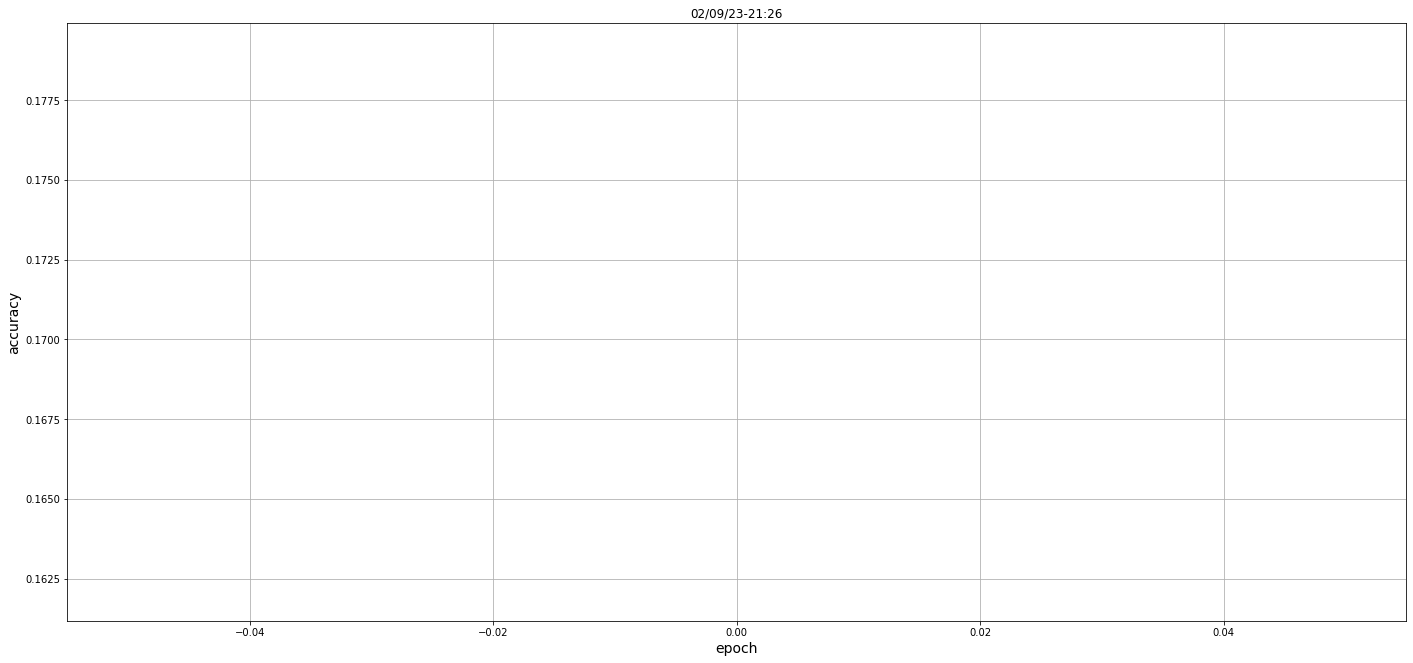

In [12]:
today: datetime = datetime.today()
now: datetime = datetime.now()

date_formatted: str = today.strftime('%m/%d/%y')
time_formatted: str = now.strftime('%H:%M')
title: str = f'{date_formatted}-{time_formatted}'

plt.figure(figsize=(24, 11))
plt.plot(history.history['accuracy'])
plt.title(title)
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('epoch', fontsize=14)
plt.grid()
plt.show()